# Bayesian Optimization

Imagine you need to find the best settings for a complex system – perhaps tuning the hyperparameters of a deep learning model, optimizing the design of an experiment, or finding the ideal parameters for a simulation. Often, evaluating the system with a given set of parameters (i.e., running the experiment or training the model) is expensive, time-consuming, or resource-intensive. How can you find the optimal settings without performing an exhaustive search?

This is where **Bayesian Optimization (BO)** comes in. It's a powerful, sequential strategy designed specifically for the **global optimization of black-box functions**. These are functions where:

1.  We don't know the underlying mathematical form (it's a "black box").
2.  Evaluating the function (getting an output `y` for an input `x`) is costly.
3.  We often cannot compute derivatives (gradients).
4.  The observations might be noisy (the output `y` can vary even for the same input `x`).

BO tackles this challenge by intelligently choosing the next point to evaluate, aiming to find the optimum (maximum or minimum) in as few evaluations as possible.

### Core Components

Bayesian Optimization cleverly balances exploring unknown parts of the search space and exploiting areas known to yield good results. It does this using two main components:

1.  **A Probabilistic Surrogate Model:** This model approximates the unknown objective function based on the points observed so far. It also provides uncertainty estimates about the function's behavior in unexplored regions. Gaussian Processes (GPs) are the most common choice for this surrogate model due to their flexibility and inherent uncertainty quantification.
2.  **An Acquisition Function:** This function uses the surrogate model's predictions (mean and uncertainty) to determine the 'utility' of evaluating any given point in the search space. It guides the search by suggesting the point that is most likely to lead to an improvement, considering both the predicted performance and the uncertainty. Examples include Expected Improvement (EI) and Upper Confidence Bound (UCB).

### The Iterative Process

The BO algorithm works iteratively:

1.  **Observe:** Evaluate the black-box function at one or more points chosen by the acquisition function.
2.  **Update:** Update the surrogate model (e.g., the Gaussian Process) using all the data collected so far (inputs and their observed outputs).
3.  **Select:** Optimize the acquisition function (which is cheap to evaluate) over the search space to find the most promising point(s) to evaluate next.
4.  **Repeat:** Continue this cycle until a stopping criterion is met (e.g., budget of function evaluations exhausted, desired performance level reached).


### Recommended reading:
1. [A Tutorial on Bayesian Optimization](https://arxiv.org/pdf/1807.02811)
1. [BayesOpt docs]((https://bayesian-optimization.github.io/BayesianOptimization/2.0.3/))
1. [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)
1. [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)
1. [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
1. [Practical Bayesian Optimization of Machine Learning Algorithms](https://arxiv.org/abs/1206.2944)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt.acquisition import UpperConfidenceBound

from matplotlib import gridspec
from bayes_opt import BayesianOptimization, TargetSpace
from bayes_opt import acquisition
from sklearn.gaussian_process import GaussianProcessRegressor

# Set random seed for reproducibility
np.random.seed(42)

### Define and visualize the target function
First, we'll create a synthetic objective function to optimize. This specific function has three peaks (at x=0, x≈2 and x≈6) and is a toy example.

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}$$

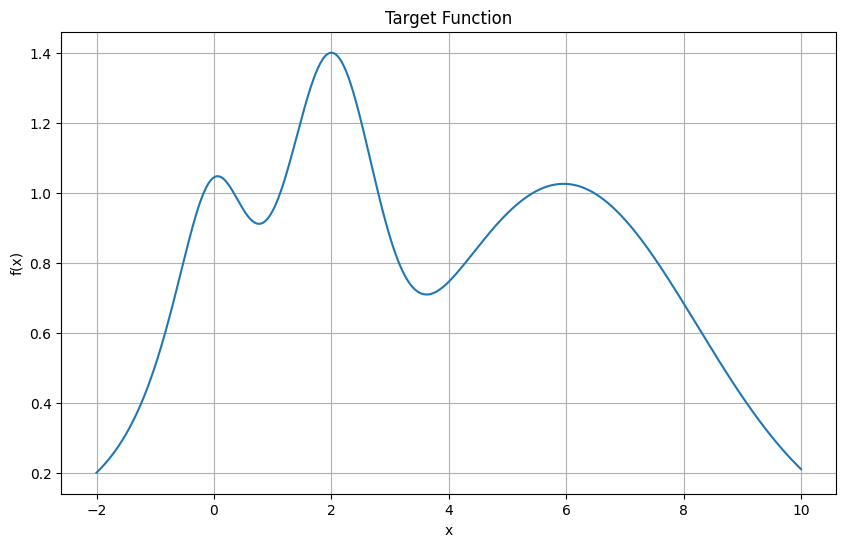

In [3]:
def target_function(x):
    """Our example target function to be optimized"""
    return np.exp(-((x - 2) ** 2)) + np.exp(-((x - 6) ** 2) / 10) + 1 / (x**2 + 1)


x = np.linspace(-2, 10, 1000)
y = target_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid(True)
plt.title("Target Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

### Define visualization functions
These helper functions will visualize the Gaussian Process model
and acquisition function at each step of the optimization process.
They help us understand how the model evolves as more observations are made.

In [4]:
def posterior(optimizer, grid):
    """Get posterior mean and standard deviation from GP model"""
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, save_path=None):
    """Plot the Gaussian Process model, observations, and acquisition function"""
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        f"Gaussian Process and Utility Function After {steps} Steps",
        fontsize=30,
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    optimizer.acquisition_function._fit_gp(optimizer._gp, optimizer._space)
    mu, sigma = posterior(optimizer, x)

    axis.plot(x, y, linewidth=3, label="Target")
    axis.plot(
        x_obs.flatten(), y_obs, "D", markersize=8, label="Observations", color="r"
    )
    axis.plot(x, mu, "--", color="k", label="Prediction")

    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=0.6,
        fc="c",
        ec="None",
        label="95% confidence interval",
    )

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel("f(x)", fontdict={"size": 20})
    axis.set_xlabel("x", fontdict={"size": 20})

    utility_function = optimizer.acquisition_function
    utility = -1 * utility_function._get_acq(gp=optimizer._gp)(x)
    x_flat = x.flatten()

    acq.plot(x_flat, utility, label="Utility Function", color="purple")
    acq.plot(
        x_flat[np.argmax(utility)],
        np.max(utility),
        "*",
        markersize=15,
        label="Next Best Guess",
        markerfacecolor="gold",
        markeredgecolor="k",
        markeredgewidth=1,
    )
    acq.set_xlim((-2, 10))
    acq.set_ylabel("Utility", fontdict={"size": 20})
    acq.set_xlabel("x", fontdict={"size": 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

    return fig

We'll now see Bayesian Optimization in action, step by step.
At each step, observe:
1. How the GP model (dashed line) is updated
2. How the confidence interval (light blue area) changes
3. How the acquisition function (purple line) guides the next sample
4. Where the next sample point (gold star) is placed

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |

Step 0: Initial random points


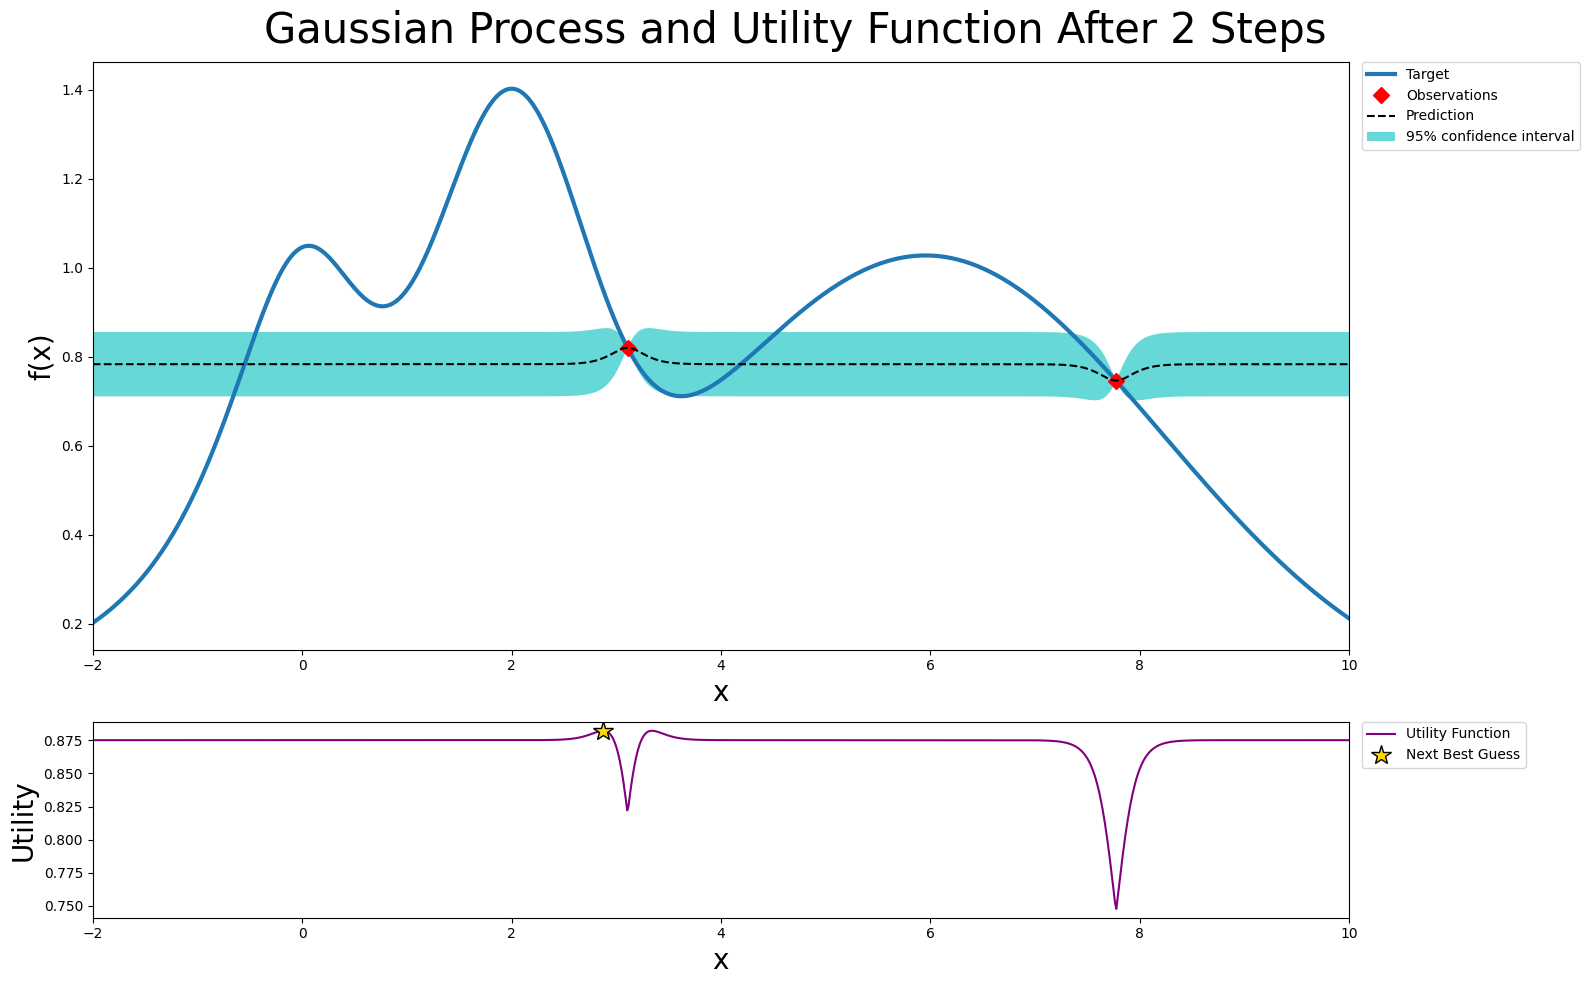

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.701     | 7.944     |

Step 1: Added a new observation


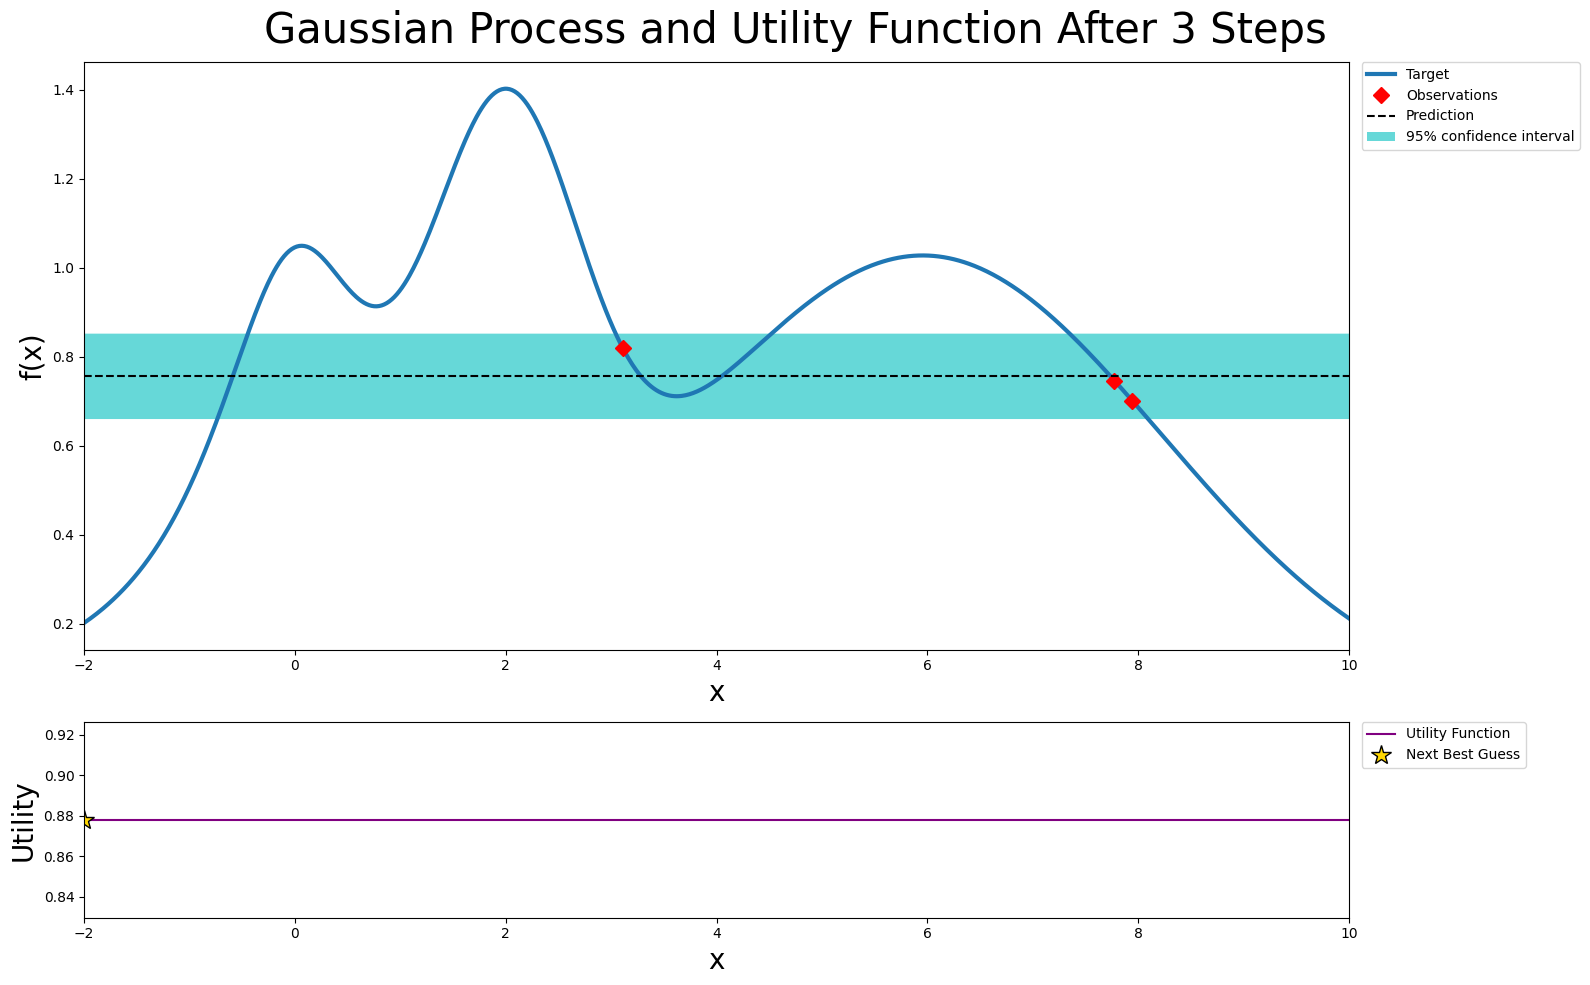

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 0.7537    | 3.29      |

Step 2: Added a new observation


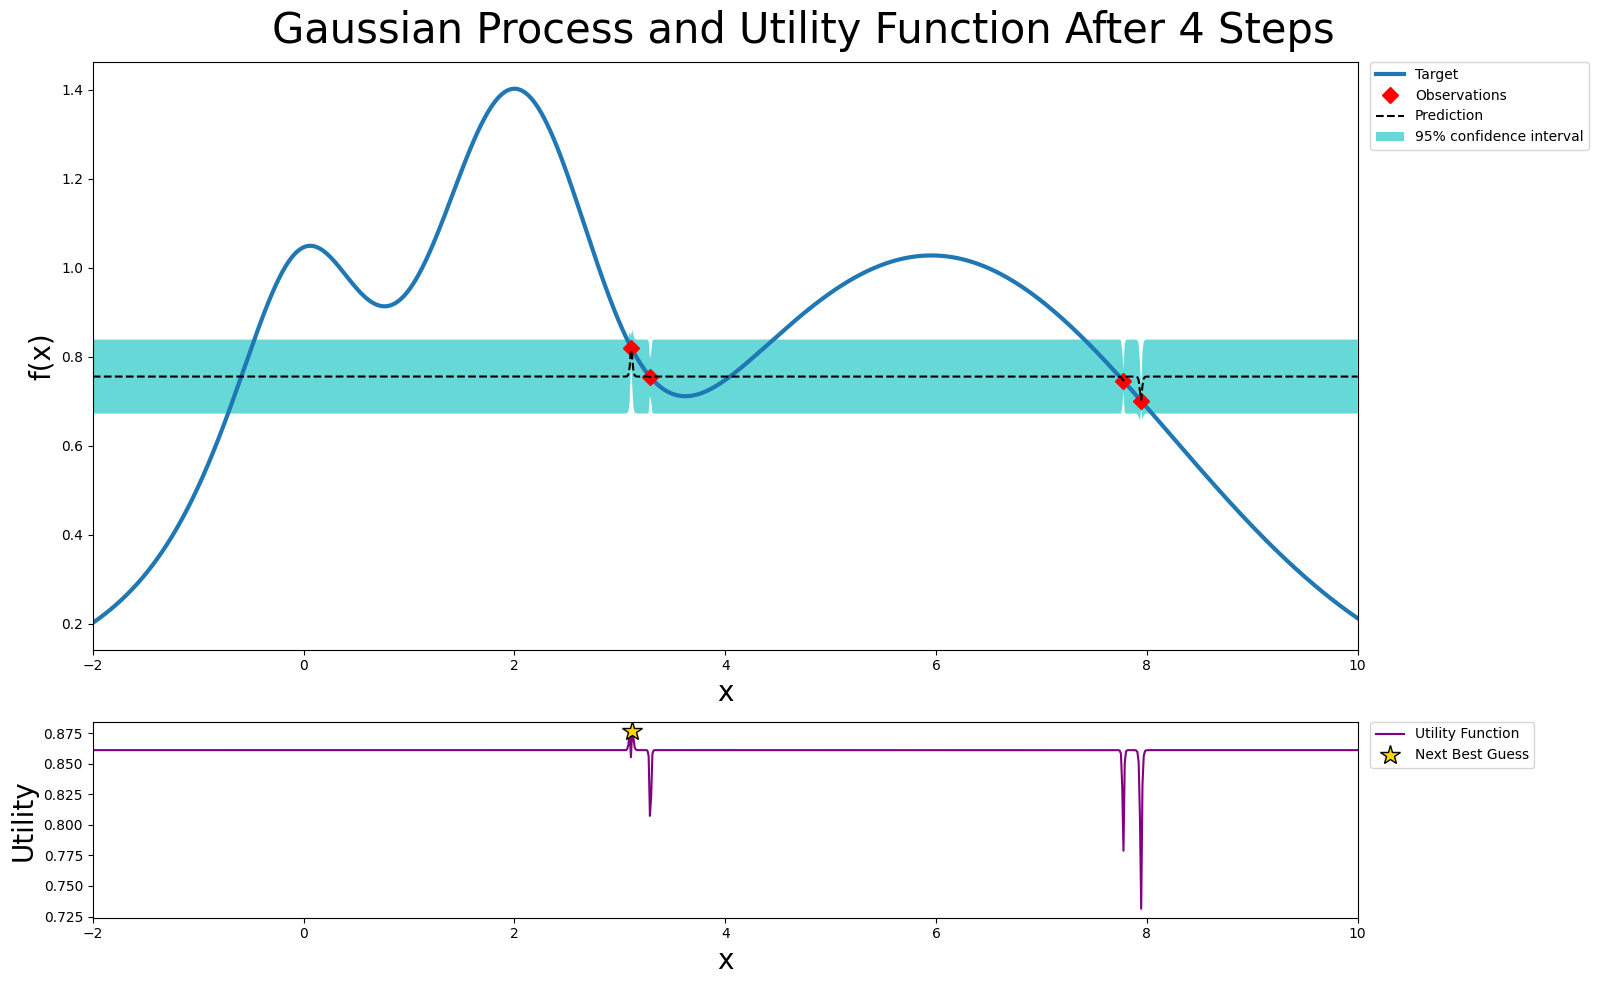

|   iter    |  target   |     x     |
-------------------------------------
| 5         | 0.8618    | 3.023     |

Step 3: Added a new observation


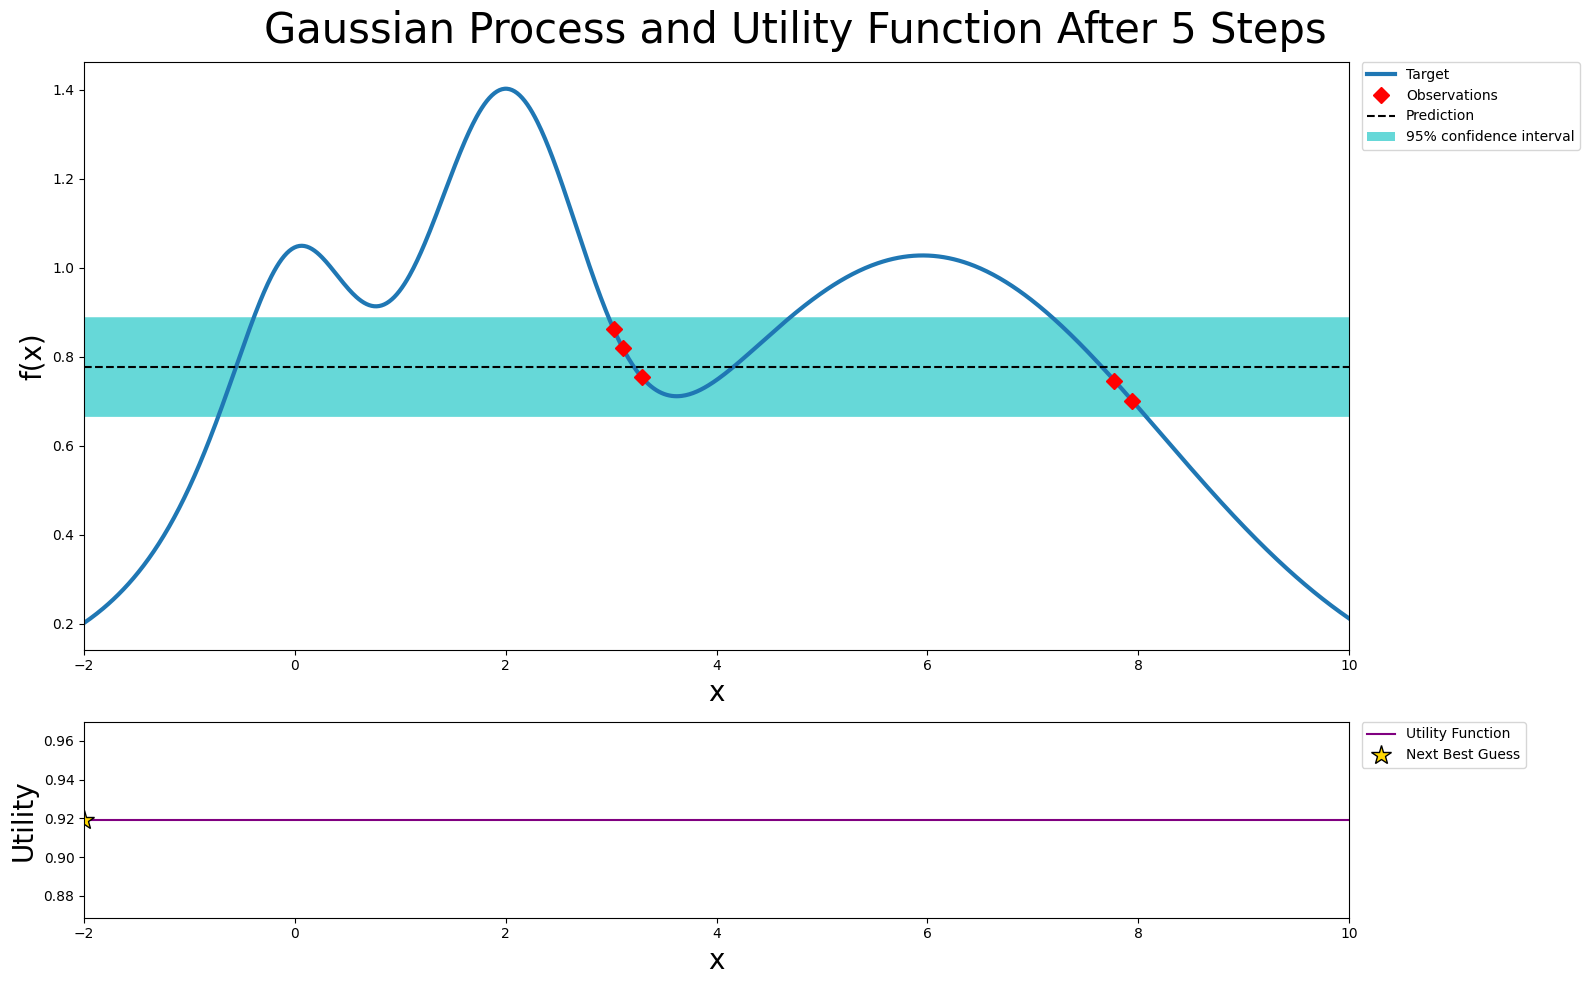

|   iter    |  target   |     x     |
-------------------------------------
| 6         | 1.268     | 2.409     |

Step 4: Added a new observation


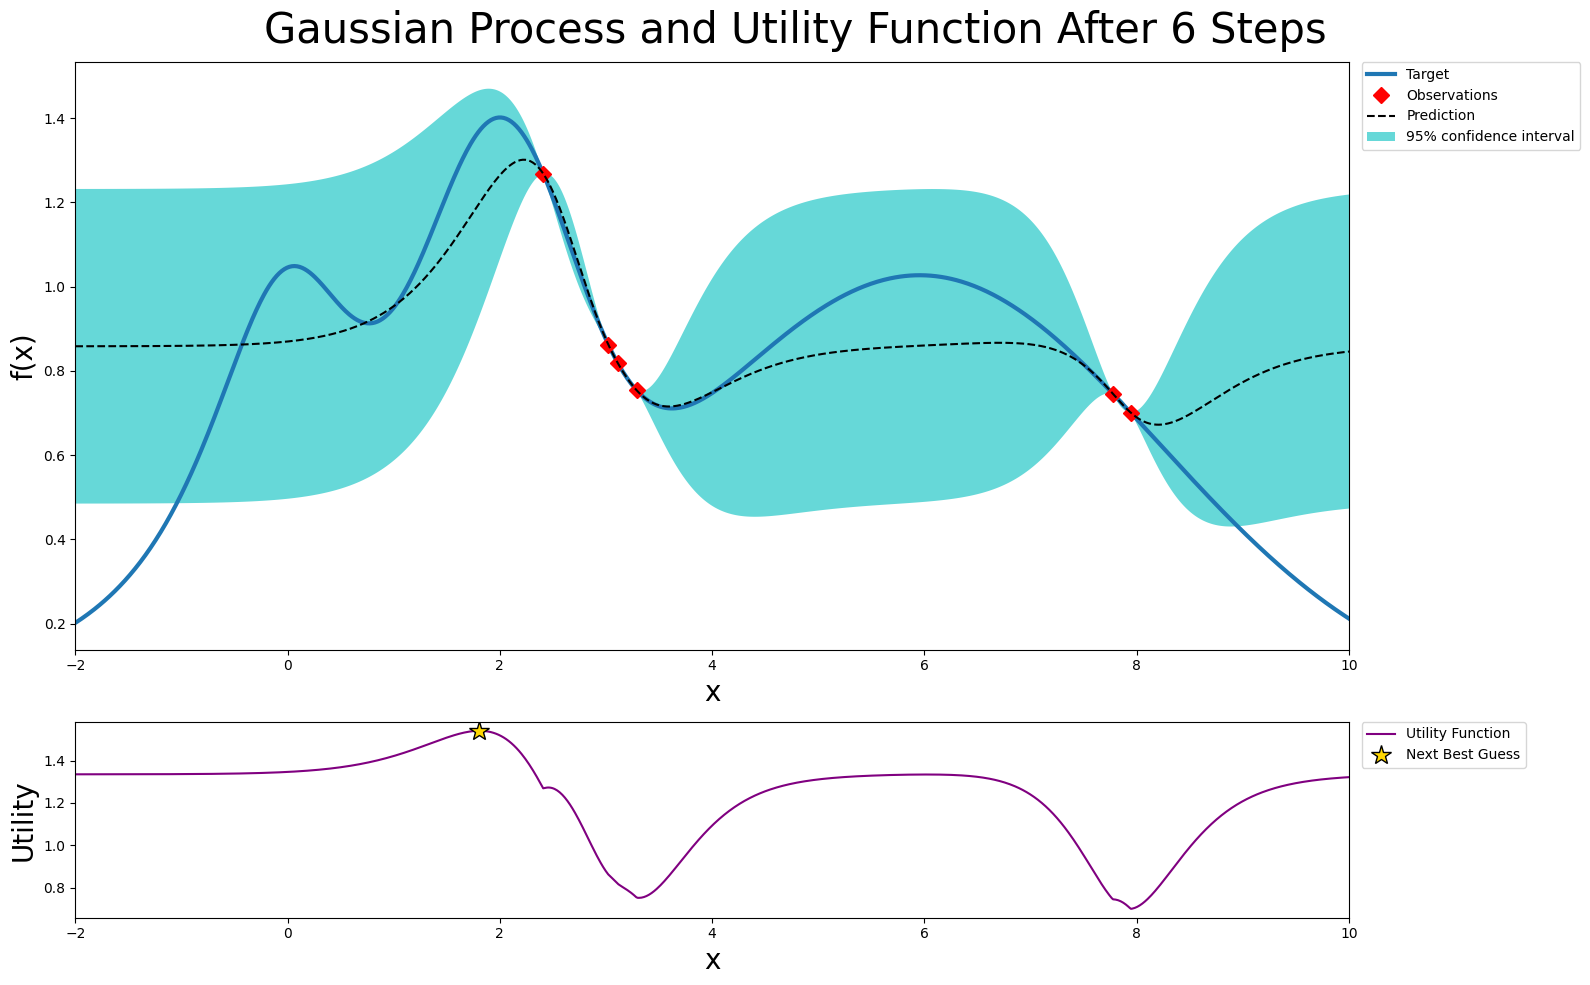

|   iter    |  target   |     x     |
-------------------------------------
| 7         | 1.371     | 1.808     |

Step 5: Added a new observation


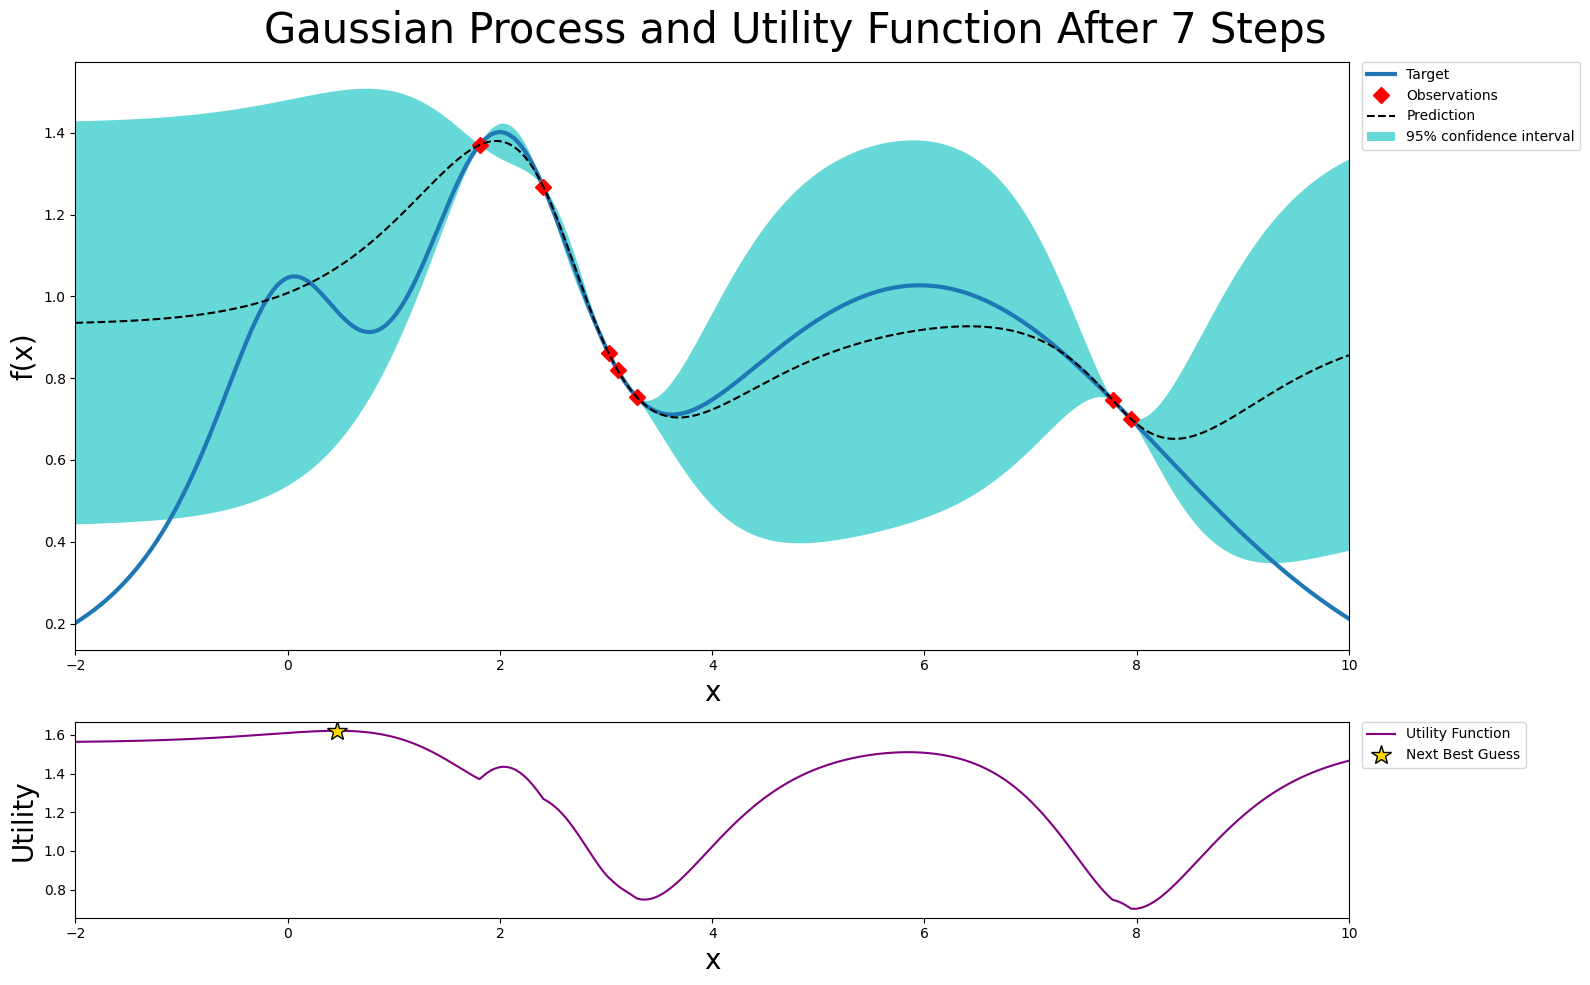


Final result:
Best target value found: 1.3705
Best input value found: x = 1.8078


In [5]:
acquisition_function = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=acquisition_function,
    random_state=27,
)

# Prepare data for visualization
x = np.linspace(-2, 10, 1000).reshape(-1, 1)
y = target_function(x)

# Initialize with 2 random points
optimizer.maximize(init_points=2, n_iter=0)
print("\nStep 0: Initial random points")
plot_gp(optimizer, x, y)

for i in range(1, 6):
    optimizer.maximize(init_points=0, n_iter=1)
    print(f"\nStep {i}: Added a new observation")
    plot_gp(optimizer, x, y)

print("\nFinal result:")
print(f"Best target value found: {optimizer.max['target']:.4f}")
print(f"Best input value found: x = {optimizer.max['params']['x']:.4f}")

Acquisition functions guide the sampling process by balancing:
- Exploitation: Sampling where the model predicts high values
- Exploration: Sampling where the model is uncertain

We'll compare three different acquisition functions:
1. Upper Confidence Bound (UCB): Balances exploration and exploitation
2. Probability of Improvement (PI): More exploitative
3. Greedy: Purely exploitative (custom implementation)

In [6]:
class GreedyAcquisition(acquisition.AcquisitionFunction):
    """Purely exploitative acquisition function (only considers mean)"""

    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        return mean  # disregard std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.9497    | 2.875     |
| 4         | 0.6622    | -0.7324   |
| 5         | 0.9503    | 6.855     |
| 6         | 0.8484    | -0.4519   |
| 7         | 0.7896    | 4.224     |
| 8         | 1.379     | 1.838     |
| 9         | 1.381     | 1.842     |
| 10        | 0.9134    | 0.7402    |
| 11        | 1.356     | 2.232     |
| 12        | 0.212     | 9.999     |

UCB Acquisition Function Results:


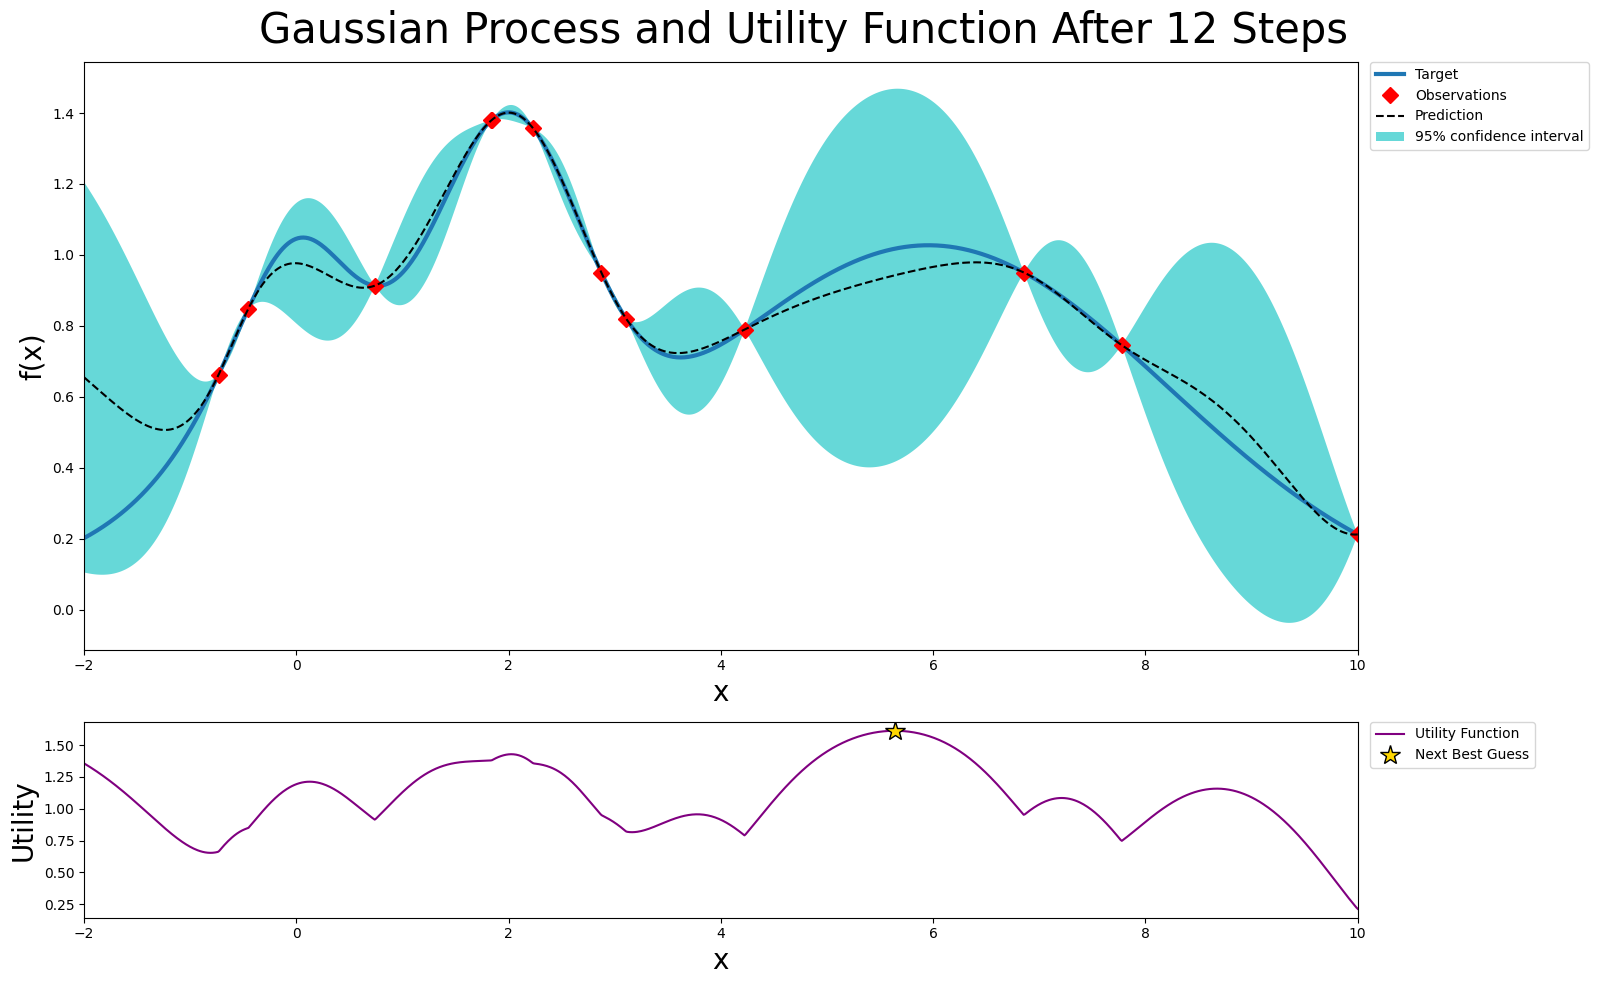

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7782    | 3.212     |
| 4         | 0.4274    | 8.965     |
| 5         | 0.818     | 3.112     |
| 6         | 0.854     | 3.038     |
| 7         | 0.8878    | 2.976     |
| 8         | 0.9183    | 2.925     |
| 9         | 0.9597    | 2.859     |
| 10        | 1.018     | 2.774     |
| 11        | 1.136     | 2.607     |
| 12        | 1.212     | 2.498     |

Probability of Improvement Acquisition Function Results:


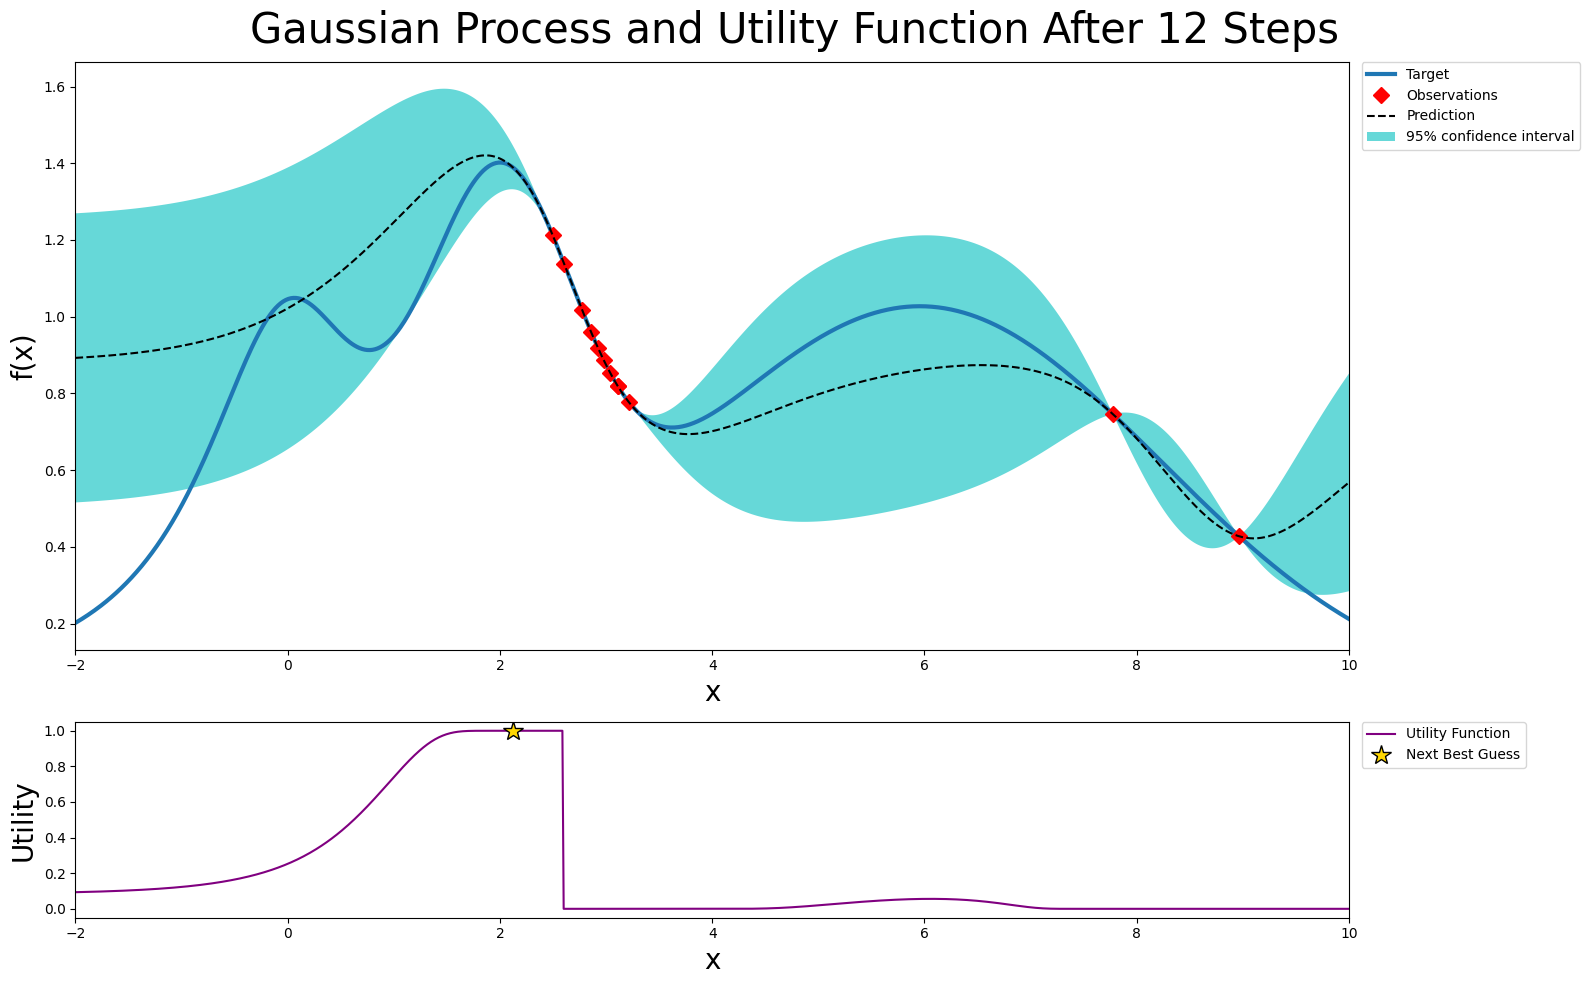

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8197    | 3.109     |
| 4         | 0.8459    | 3.054     |
| 5         | 0.8669    | 3.014     |
| 6         | 0.9042    | 2.948     |
| 7         | 0.9606    | 2.858     |
| 8         | 1.051     | 2.726     |
| 9         | 1.198     | 2.519     |
| 10        | 1.377     | 2.172     |
| 11        | 1.377     | 1.829     |
| 12        | 1.402     | 2.01      |

Greedy (Purely Exploitative) Acquisition Function Results:


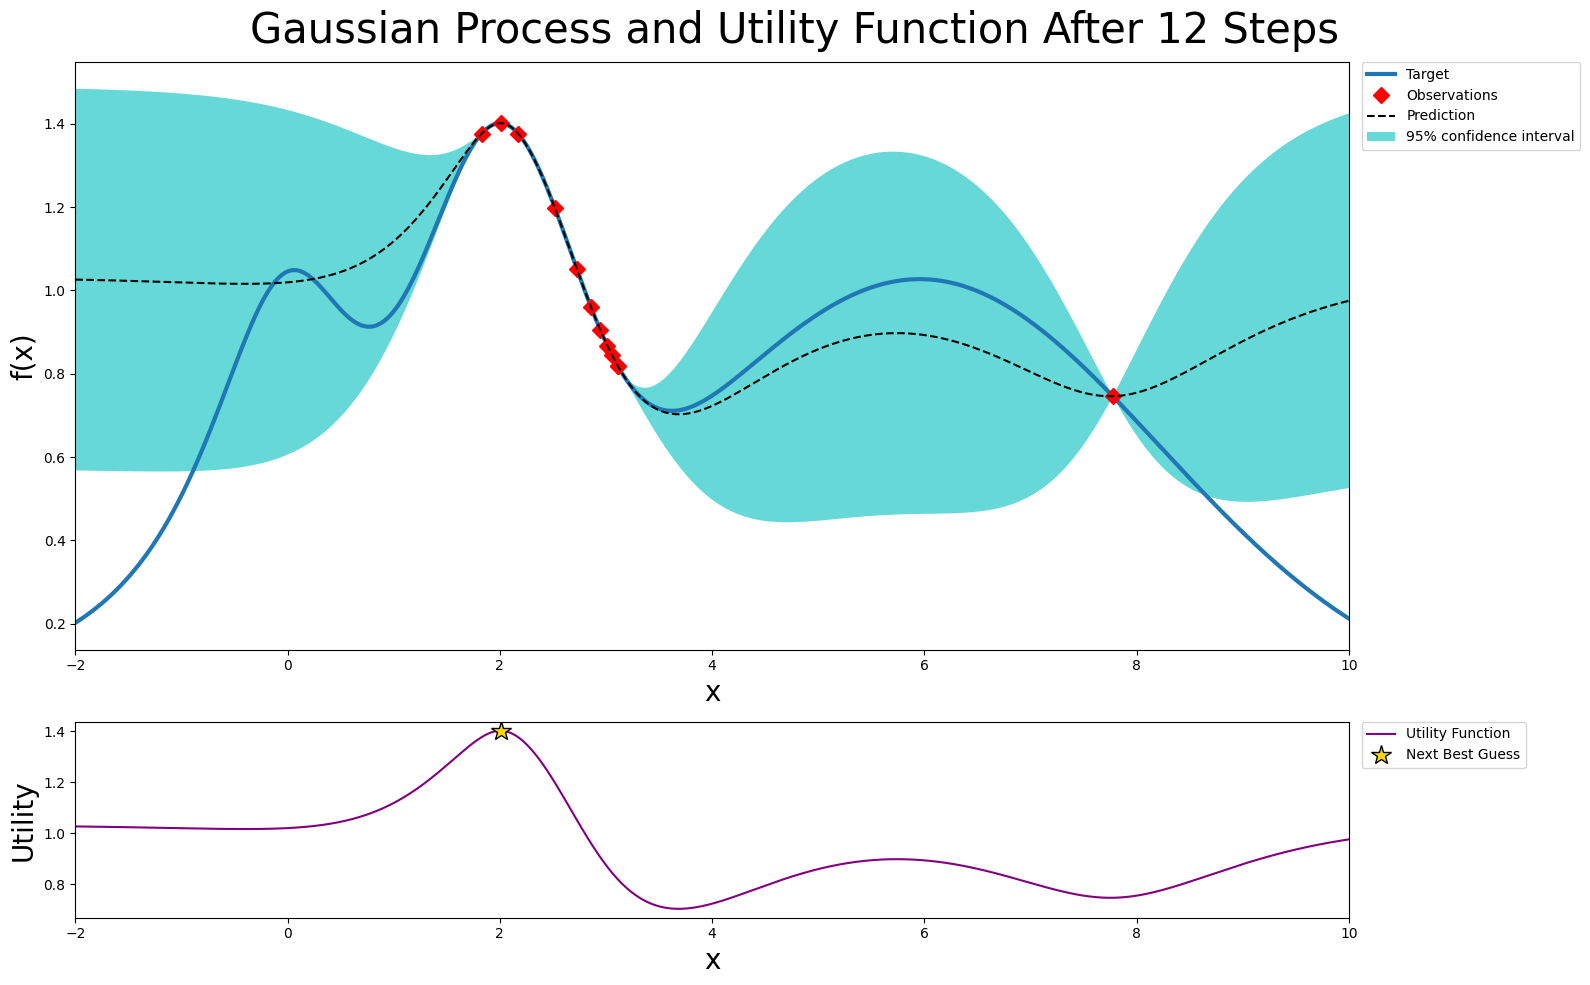


Summary of results:
UCB best value: 1.3805 at x = 1.8422
PI best value: 1.2116 at x = 2.4983
Greedy best value: 1.4018 at x = 2.0097


In [43]:
ucb = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)

optimizer_ucb.maximize(init_points=2, n_iter=10)
print("\nUCB Acquisition Function Results:")
plot_gp(optimizer_ucb, x, y)

# Run with PI
pi = acquisition.ProbabilityOfImprovement(xi=1e-2)
optimizer_pi = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=pi,
    random_state=27,
)

optimizer_pi.maximize(init_points=2, n_iter=10)
print("\nProbability of Improvement Acquisition Function Results:")
plot_gp(optimizer_pi, x, y)

# Run with Greedy
greedy = GreedyAcquisition()
optimizer_greedy = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=greedy,
    random_state=27,
)

optimizer_greedy.maximize(init_points=2, n_iter=10)
print("\nGreedy (Purely Exploitative) Acquisition Function Results:")
plot_gp(optimizer_greedy, x, y)

# Summary
print("\nSummary of results:")
print(
    f"UCB best value: {optimizer_ucb.max['target']:.4f} at x = {optimizer_ucb.max['params']['x']:.4f}"
)
print(
    f"PI best value: {optimizer_pi.max['target']:.4f} at x = {optimizer_pi.max['params']['x']:.4f}"
)
print(
    f"Greedy best value: {optimizer_greedy.max['target']:.4f} at x = {optimizer_greedy.max['params']['x']:.4f}"
)

Comment these results. Write your observations in a Markdown cell.

Exercise 1: UCB
---------------

The parameter kappa in the UCB acquisition function controls the trade-off between:
- Exploration (high kappa): More emphasis on the uncertainty
- Exploitation (low kappa): More emphasis on the predicted mean

Compare results for UCB using 3 different values:
1. kappa = 0.1 (Mostly exploitation)
2. kappa = 2.5 (Balanced)
3. kappa = 5.0 (Mostly exploration)

Review this [blog post](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html) and explain the underlying concept of UCB in a Markdown cell.

In [8]:
kappa_tab = [0.1, 2.5, 5.0]

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8134    | 3.123     |
| 4         | 0.8199    | 3.108     |
| 5         | 0.8471    | 3.052     |
| 6         | 0.878     | 2.994     |
| 7         | 0.926     | 2.912     |
| 8         | 1.004     | 2.793     |
| 9         | 1.134     | 2.61      |
| 10        | 1.32      | 2.315     |
| 11        | 1.39      | 1.881     |
| 12        | 1.402     | 1.98      |

UCB Acquisition Function with kappa=0.1 Results:


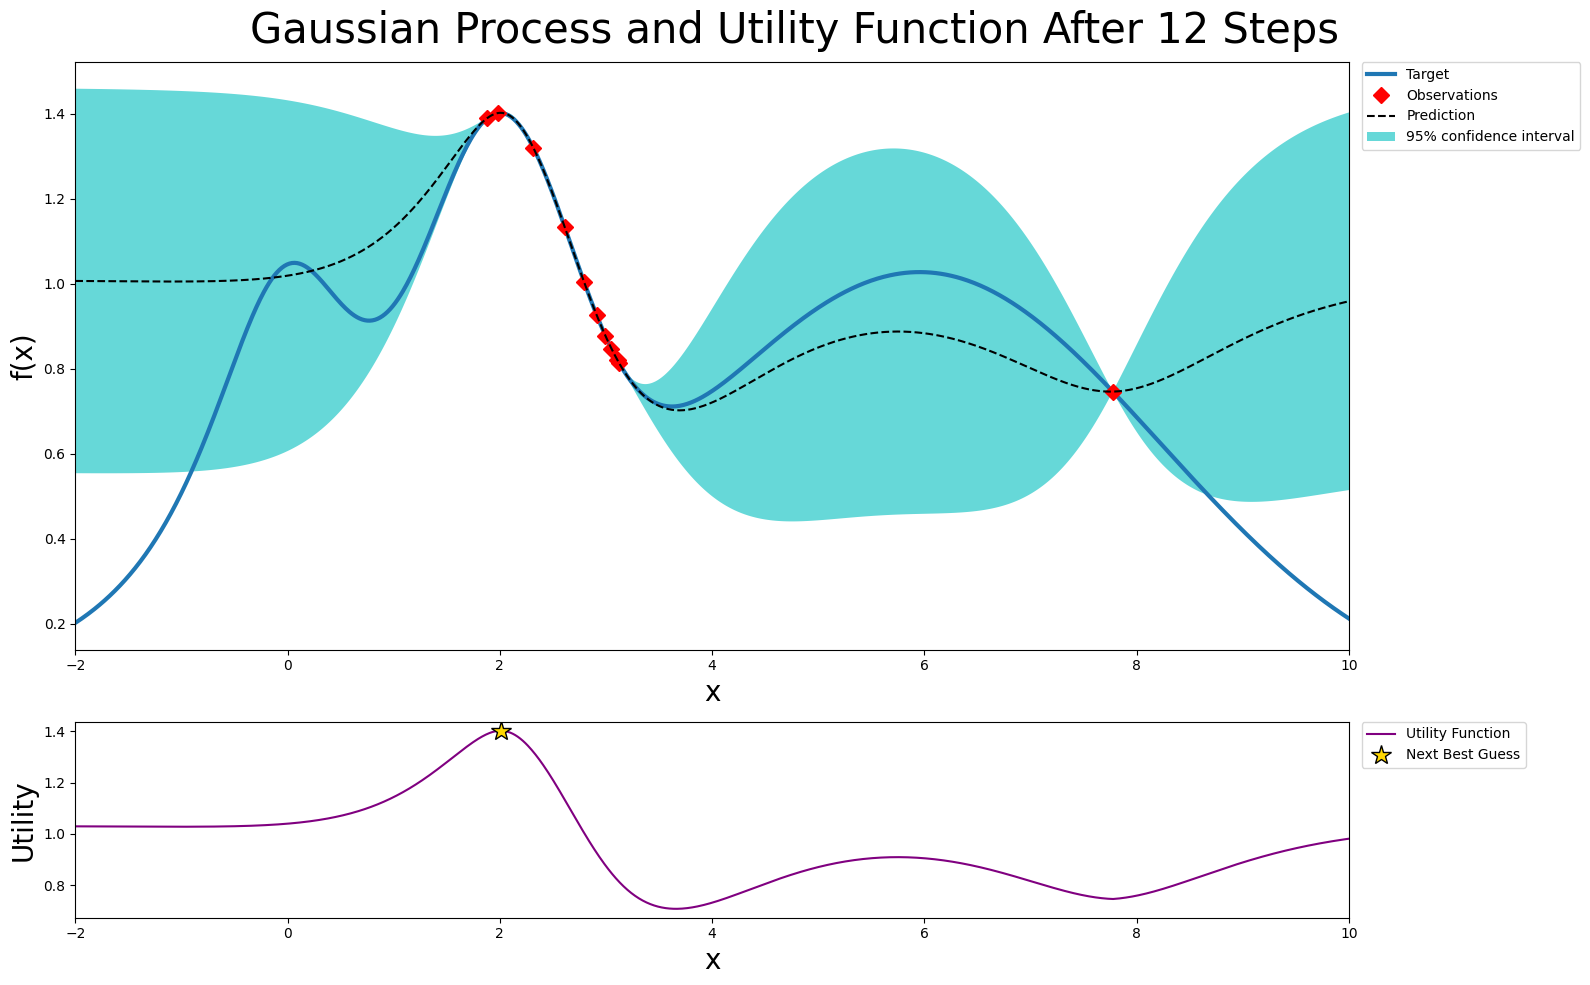

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7406    | 3.342     |
| 4         | 0.8197    | 3.109     |
| 5         | 0.9017    | 2.952     |
| 6         | 1.021     | 2.769     |
| 7         | 1.228     | 2.474     |
| 8         | 1.379     | 1.837     |
| 9         | 0.9342    | 0.581     |
| 10        | 0.2018    | -1.999    |
| 11        | 0.2119    | 9.999     |
| 12        | 1.027     | 5.878     |

UCB Acquisition Function with kappa=2.5 Results:


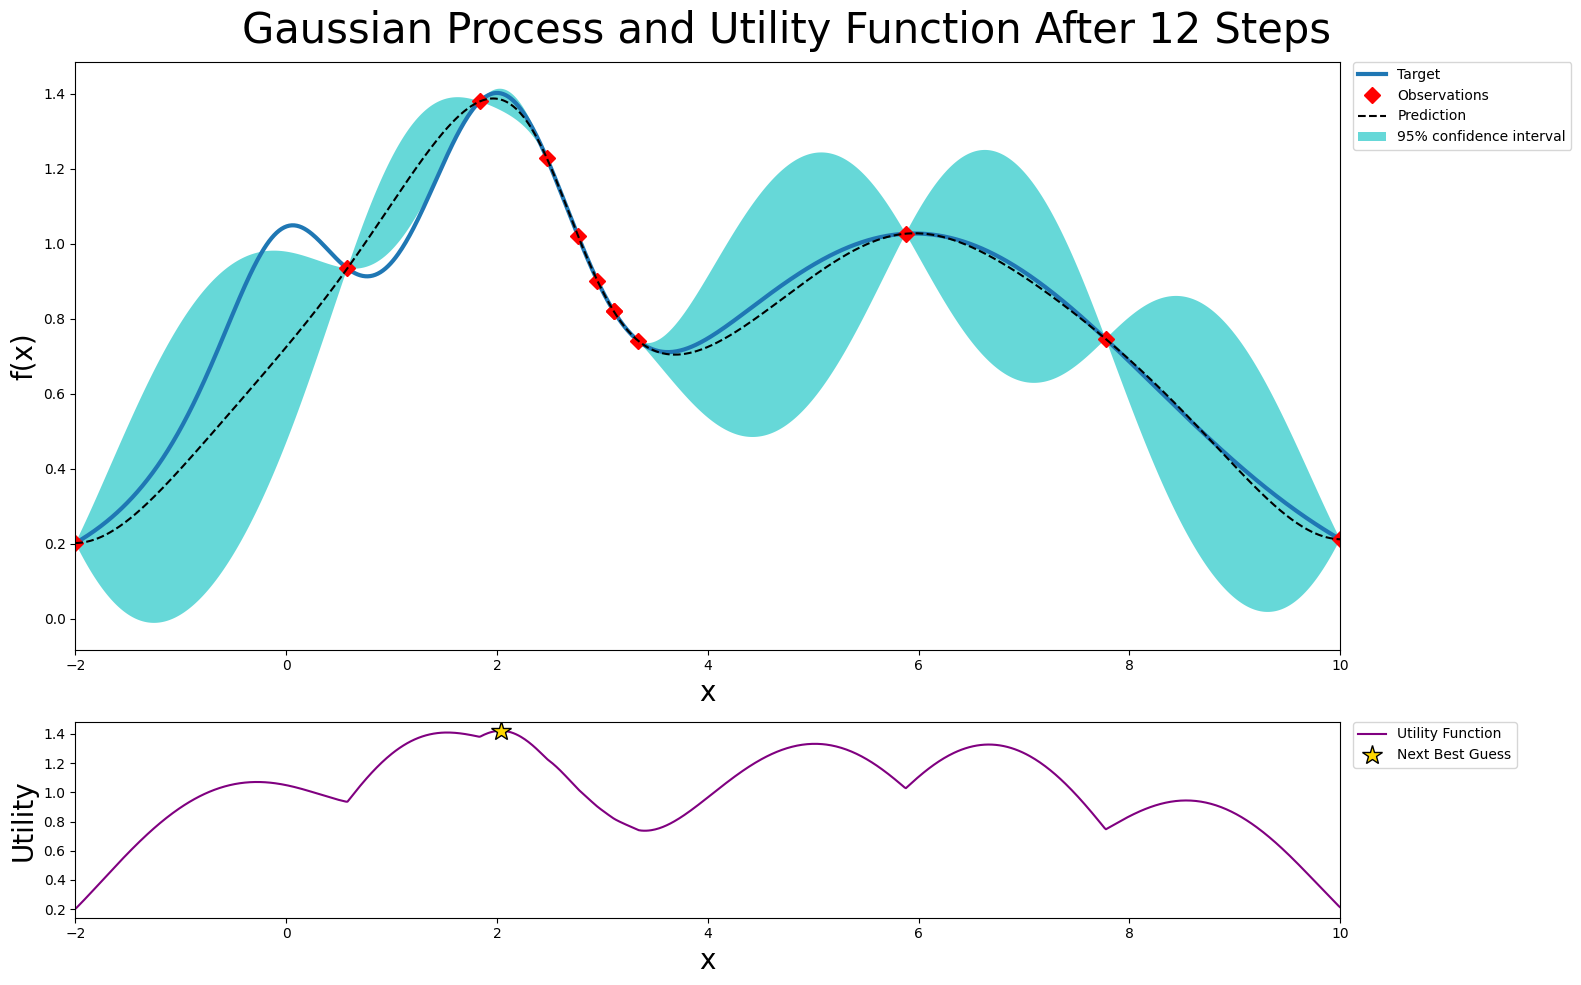

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 1.007     | 2.79      |
| 4         | 0.859     | 4.555     |
| 5         | 1.007     | 2.789     |
| 6         | 1.183     | 2.541     |
| 7         | 1.392     | 2.107     |
| 8         | 0.9134    | 0.7425    |
| 9         | 0.2018    | -1.999    |
| 10        | 0.2118    | 10.0      |
| 11        | 1.024     | 6.146     |
| 12        | 0.83      | -0.4798   |

UCB Acquisition Function with kappa=5.0 Results:


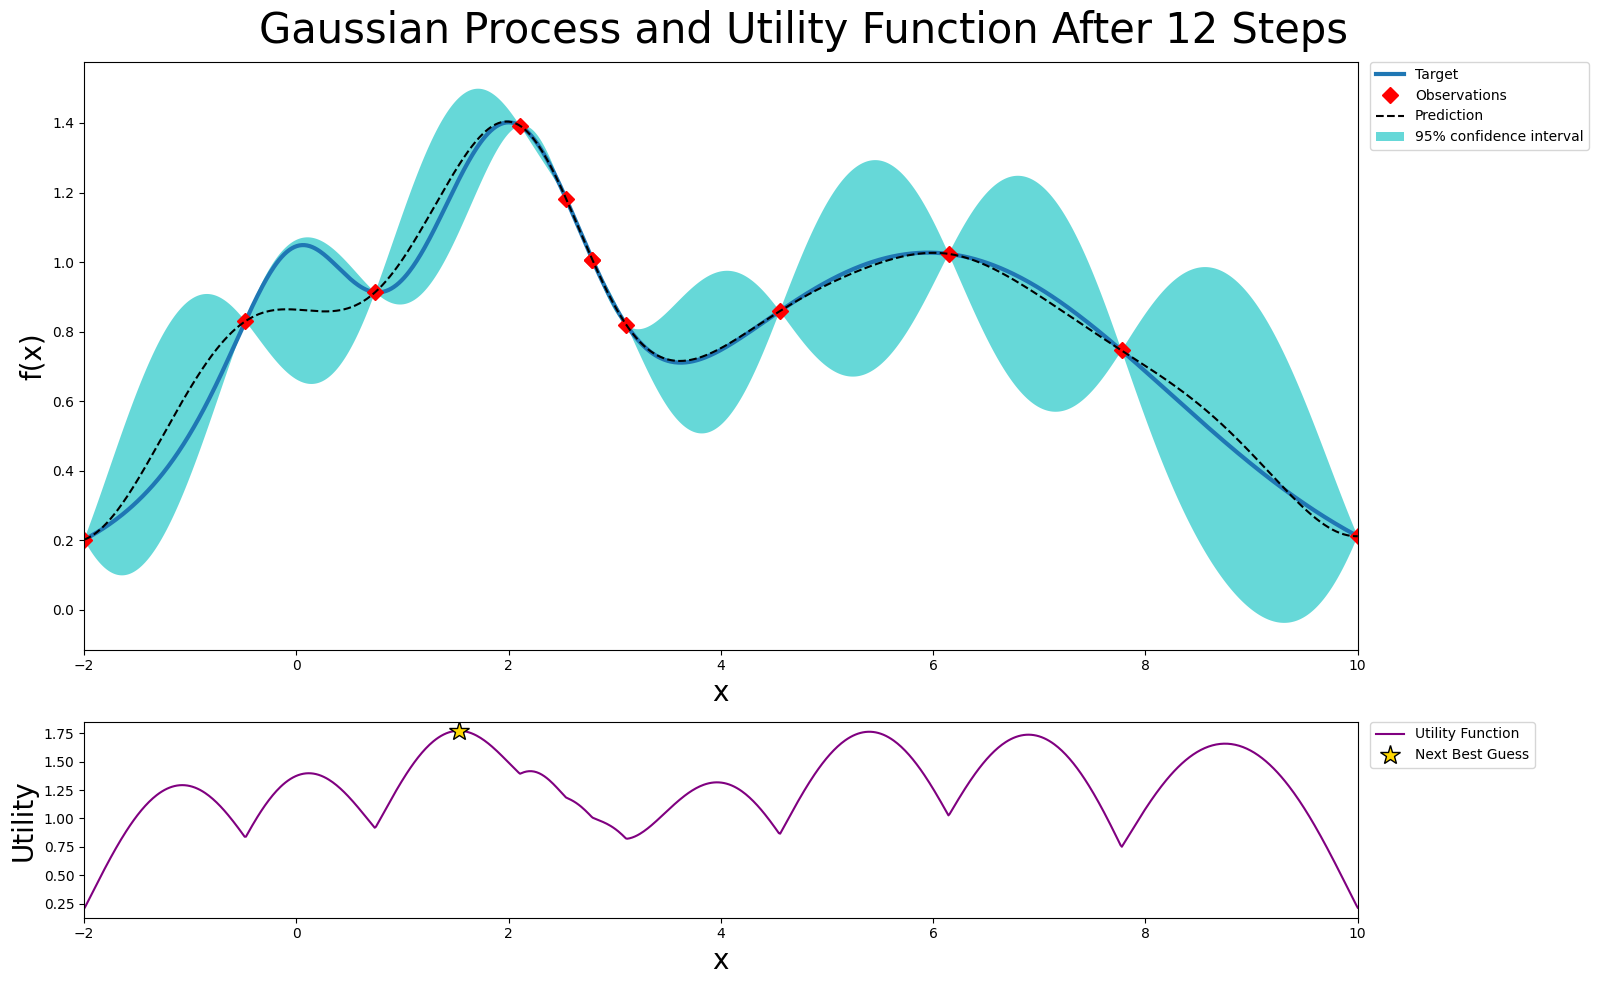

In [44]:
for kappa in kappa_tab: 
    ucb = acquisition.UpperConfidenceBound(kappa=kappa)
    optimizer_ucb = BayesianOptimization(
        f=target_function,
        pbounds={"x": (-2, 10)},
        acquisition_function=ucb,
        random_state=27,
    )
    
    optimizer_ucb.maximize(init_points=2, n_iter=10)
    print(f"\nUCB Acquisition Function with {kappa=} Results:")
    plot_gp(optimizer_ucb, x, y)

The UCB is an acquisition function used in Bayesian Optimization to balance the trade-off between exploration (visiting unseen areas) and exploitation (sampling points with high predicted performance). Based on those information and value of kappa, it decides where to sample next. In my example, we can see that function with high value of kappa explored more area than others. The Low value of kappa did not explore at all. We can see that it is best to use balanced value of kappa (sometimes high kappa got the best value of target function, but I think it was just a lucky guess)  

Exercise 2: Chaotic Acquisition Function
-----------------------------------------
**Goal**: Implement a chaotic acquisition function that exclusively prioritizes the standard deviation of predictions, disregarding the predicted mean. Compare its performance against standard acquisition functions such as UCB and PI (Probability of Improvement).

In [25]:
class Chaotic(acquisition.AcquisitionFunction):
    def base_acq(self, mean, std):
        return std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8689    | -0.4204   |
| 4         | 0.2121    | 9.998     |
| 5         | 1.022     | 5.734     |
| 6         | 0.2023    | -1.996    |
| 7         | 0.7899    | 4.225     |
| 8         | 1.12      | 1.342     |
| 9         | 0.4433    | 8.902     |

Chaotic Acquisition Function Results:


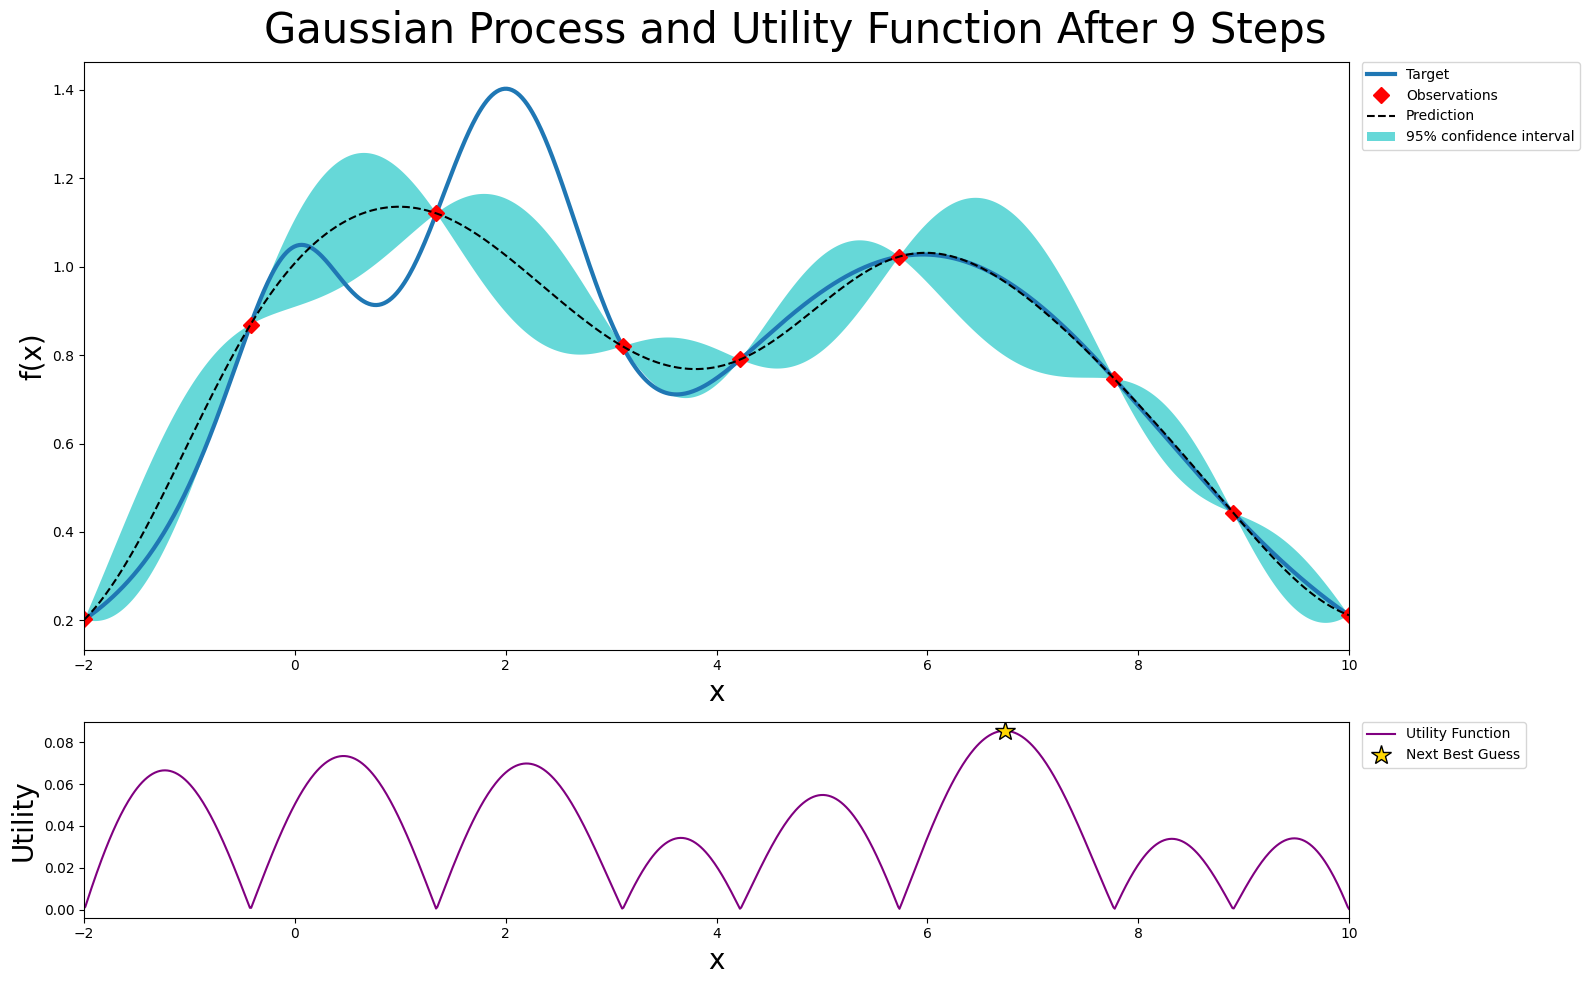

In [27]:
chaotic = Chaotic()

optimizer_chaotic = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=chaotic,
    random_state=27,
)

optimizer_chaotic.maximize(init_points=2, n_iter=7)
print("\nChaotic Acquisition Function Results:")
plot_gp(optimizer_chaotic, x, y);

Looking only at the standard deviation means that we are committed fully to exploration. \
Looking at the charts from earlier, UCB Acquisition Function with kappa=2.5 is currently the best as it is both exploring and trying to improve with every step.
PI focuses on areas near known good points and can get stucked in local optima

Exercise 3: Expected Improvement
--------------------------------

**Goal:** Implement the Expected Improvement (EI) acquisition function by extending the `AcquisitionFunction` base class provided by the `BayesOpt` library.

Expected Improvement (EI) is a popular choice for the acquisition function. Let's understand its derivation:

1.  **Current Best:** After $n$ evaluations, the best function value observed *so far* is $f^* = \max_{m=1..n} f(x_m)$.

2.  **Potential Improvement:** If we evaluate a new point $x$, the *actual* improvement over the current best $f^*$ is $\max(f(x) - f^*, 0)$, sometimes written as $[f(x) - f^*]^+$.

3.  **The Challenge:** We want to choose $x$ to maximize this improvement, but $f(x)$ is unknown *before* evaluation.

4.  **The Solution: Expected Improvement:** Our probabilistic model gives a posterior distribution for $f(x)$ at any point $x$. Given the data, this is typically a Gaussian distribution: $f(x) \sim \mathcal{N}(\mu_n(x), \sigma_n^2(x))$. EI maximizes the *expected* value of the improvement, where the expectation is taken over this posterior distribution:

    $EI_n(x) = E_n[ \max(f(x) - f^*, 0) ]$

    This value represents, on average, how much we expect to improve upon $f^*$ by evaluating at $x$. The next point chosen is the one that maximizes $EI_n(x)$.

### Mathematical Formulation

The expected improvement integral can be computed analytically. The standard closed-form expression is:

$$
EI(x) =
\begin{cases}
(\mu(x) - f^*) \Phi(Z) + \sigma(x) \varphi(Z) & \text{if } \sigma(x) > 0 \\
0 & \text{if } \sigma(x) = 0
\end{cases}
$$

Where:

* $\mu(x)$: The posterior mean of $f(x)$ at point $x$.
* $\sigma(x)$: The posterior standard deviation of $f(x)$ at point $x$.
* $f^*$: The best function value observed so far (a single scalar value).
* $Z = \frac{\mu(x) - f^*}{\sigma(x)}$
* $\Phi(Z)$: The Cumulative Distribution Function (CDF) of the standard normal distribution $\mathcal{N}(0, 1)$.
* $\varphi(Z)$: The Probability Density Function (PDF) of the standard normal distribution $\mathcal{N}(0, 1)$.

### Implementation Task

Create a class `ExpectedImprovement` inheriting from `acquisition.AcquisitionFunction` and implement the core calculation in the `base_acq` method. The signature of `base_acq` method looks like this:
```python
def base_acq(self, mean: NDArray[Float], std: NDArray[Float]) -> NDArray[Float]: pass
```

Compare its performance against other acquisition functions.

Hint: Analyse the source code of `UpperConfidenceBound` class to better understand how to use/update $f^*$ (`self.y_max`).

In [34]:
from typing import Any
from numpy._typing import NDArray
from scipy.stats import norm
from bayes_opt.exception import NoValidPointRegisteredError
from sklearn.gaussian_process import GaussianProcessRegressor
from bayes_opt.target_space import TargetSpace

Float = np.floating[Any]

In [ ]:
acquisition.ProbabilityOfImprovement

In [35]:
class ExpectedImprovement(acquisition.AcquisitionFunction):
    def __init__(self):
        super().__init__()
        self.y_max = None
        
        
    def base_acq(self, mean: NDArray[Float], std: NDArray[Float]) -> NDArray[Float]:
        if self.y_max is None:
            msg = (
                "y_max is not set. If you are calling this method outside "
                "of suggest(), you must set y_max manually."
            )
            raise ValueError(msg)
        
        mat = np.zeros(mean.shape)
        indexes = np.nonzero(std)
        z = (mean - self.y_max) / std
        mat[indexes] = (mean[indexes] - self.y_max) * norm.cdf(z[indexes]) + std[indexes] * norm.pdf(z[indexes])
        return mat
    
    def suggest(
        self,
        gp: GaussianProcessRegressor,
        target_space: TargetSpace,
        n_random: int = 10_000,
        n_l_bfgs_b: int = 10,
        fit_gp: bool = True,
    ) -> NDArray[Float]:
        
        y_max = target_space._target_max()
        if y_max is None and not target_space.empty:
            # If target space is empty, let base class handle the error
            msg = (
                "Cannot suggest a point without an allowed point. Use "
                "target_space.random_sample() to generate a point until "
                " at least one point that satisfies the constraints is found."
            )
            raise NoValidPointRegisteredError(msg)
        self.y_max = y_max
        x_max = super().suggest(
            gp=gp, target_space=target_space, n_random=n_random, n_l_bfgs_b=n_l_bfgs_b, fit_gp=fit_gp
        )

        return x_max

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8902    | 2.972     |
| 4         | 0.9421    | 4.992     |
| 5         | 0.9421    | 4.992     |
| 6         | 0.9637    | 5.13      |
| 7         | 0.9898    | 5.328     |
| 8         | 1.014     | 5.588     |
| 9         | 1.027     | 5.914     |
| 10        | 1.296     | 2.36      |
| 11        | 1.392     | 2.11      |
| 12        | 1.363     | 1.785     |

Expected Improvement Acquisition Function Results:


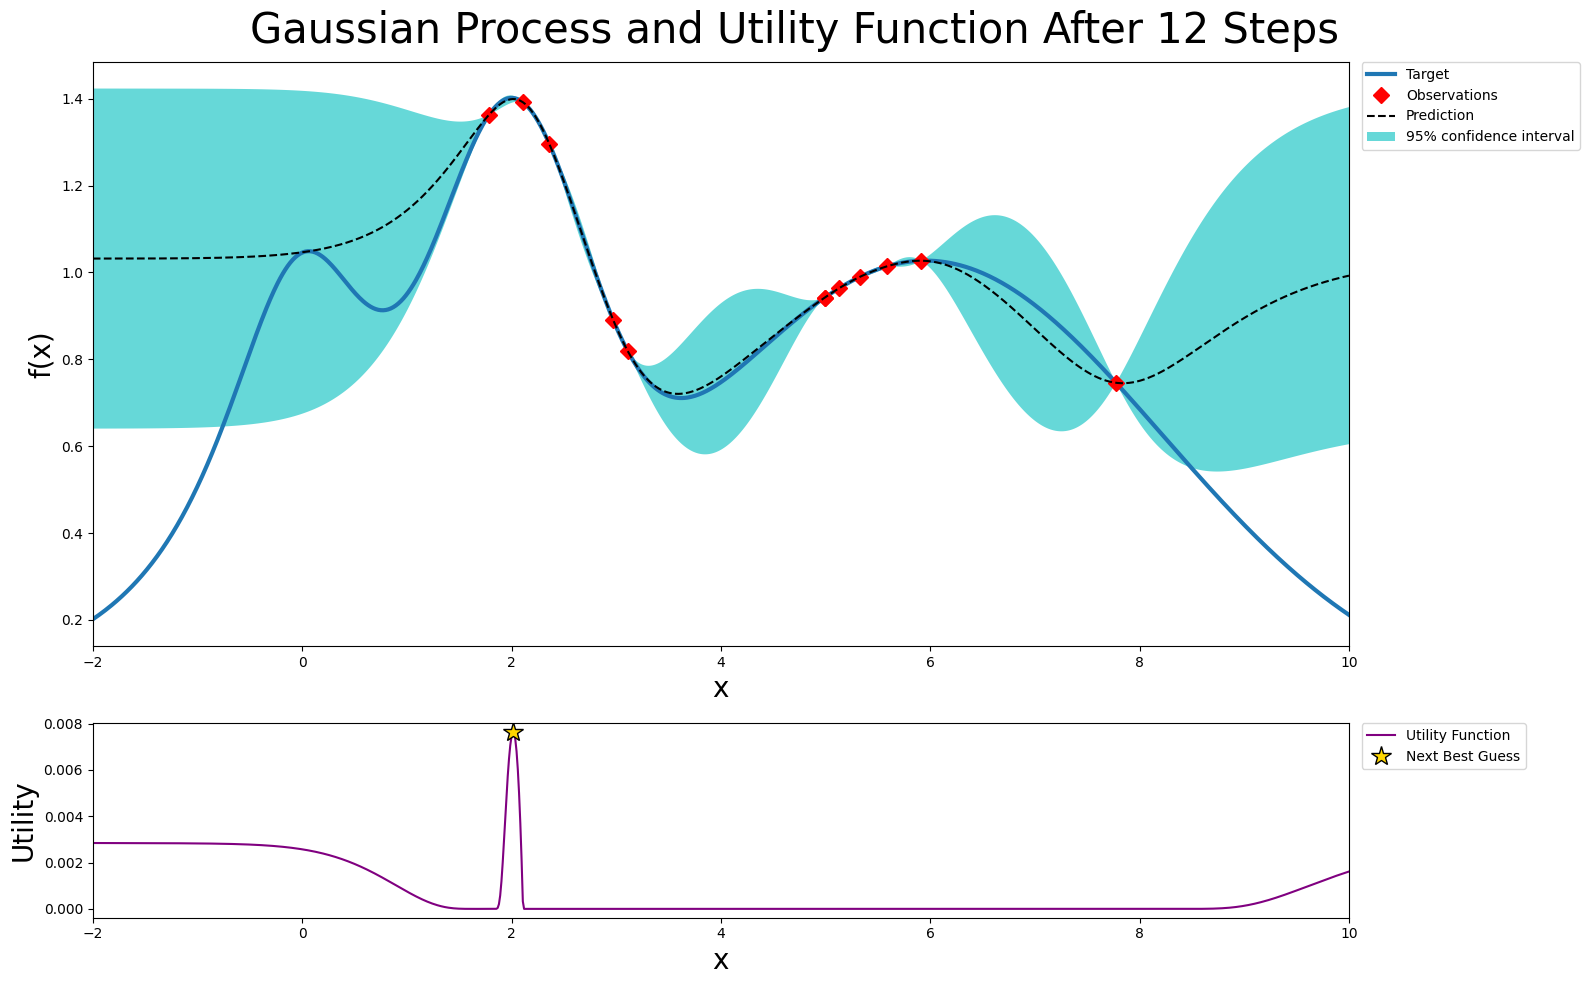

In [47]:
ei = ExpectedImprovement()
optimizer_ei = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ei,
    random_state=27,
)

optimizer_ei.maximize(init_points=2, n_iter=10)
print("\nExpected Improvement Acquisition Function Results:")
plot_gp(optimizer_ei, x, y);

Expected Improvement extends PI by considering both the probability of improvement and the expected magnitude of that improvement. I compared EI with balanced UCB, but I got similar results. I think that UCB might be less likely to get stuck in local minima than EI, but I was not able to prove it empirically 

Exercise 4: Theoretical Questions
--------------------------------
1. Why is Bayesian Optimization particularly useful for expensive-to-evaluate functions?
2. Compare and contrast the different acquisition functions discussed in this tutorial.
3. What are the limitations of Bayesian Optimization?

1. Because it builds a cheap surrogate model to approximate the objective, allowing it to find good solutions with fewer evaluations
2. 
- **PI**: Focuses on the probability of improving over the best result. Simple, but can be greedy.
- **EI**: Considers both probability and size of improvement. More balanced than PI.
- **UCB**: Balances exploration and exploitation using a hiperparameter kappa. I believe that it avoid local optima better. 
3.
- Doesn’t scale well to high-dimensional spaces.
- Assumes smooth, continuous functions.
- Surrogate models (like Gaussian Processes) can become slow with large data.